In [1]:
import getfem as gf
import numpy as np
import pyvista as pv

pv.start_xvfb()

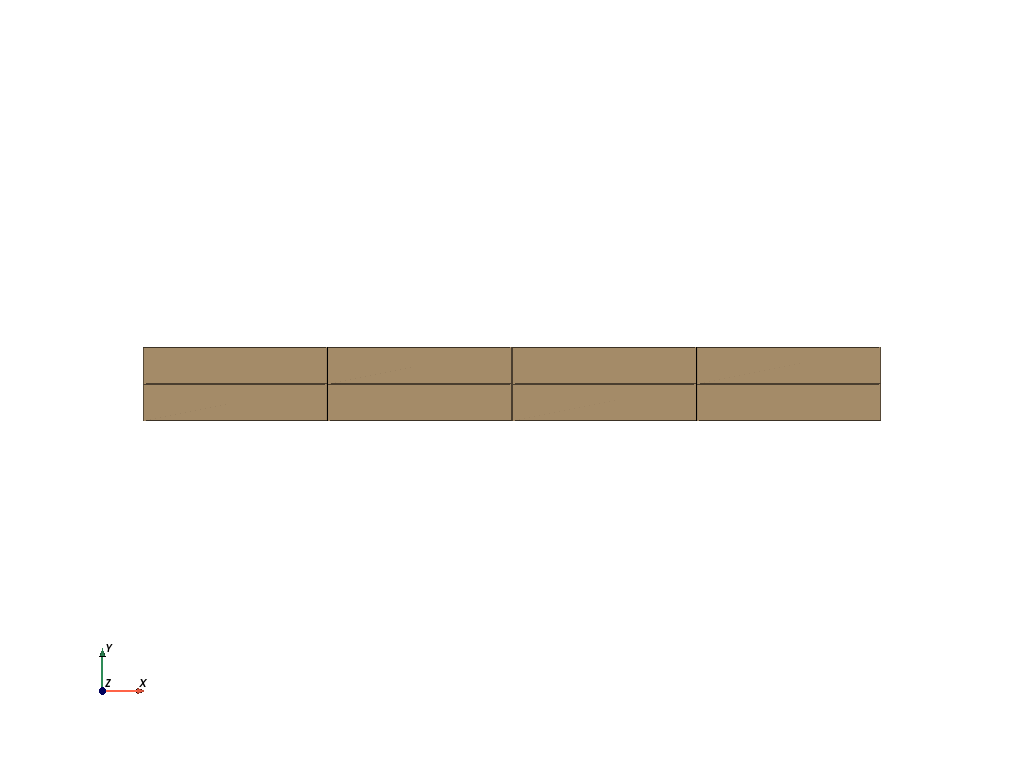

In [2]:
b = 1.0 # mm
L = 10000.0 # mm
h = 1000.0 # mm
X = np.linspace(0.0, L, 4 + 1)
Y = np.linspace(0.0, h, 2 + 1)
mesh = gf.Mesh("cartesian", X, Y)
mesh.export_to_vtk("mesh.vtk", "ascii")
m = pv.read("mesh.vtk")
m.plot(show_edges="True", cpos="xy", jupyter_backend="static")

In [3]:
fb1 = mesh.outer_faces_with_direction([-1.0, 0.0], 0.01)
fb2 = mesh.outer_faces_with_direction([1.0, 0.0], 0.01)
LEFT = 1
RIGHT = 2
mesh.set_region(LEFT, fb1)
mesh.set_region(RIGHT, fb2)

In [4]:
mfu = gf.MeshFem(mesh, 2)
elements_degree = 2
mfu.set_classical_fem(elements_degree)

In [5]:
im = gf.Integ("IM_PRODUCT(IM_GAUSS1D(4), IM_GAUSS1D(4))")
mim = gf.MeshIm(mesh, im)

In [6]:
E = 205000.0 # N/mm2
nu = 0.0
md = gf.Model("real")
md.add_fem_variable("u", mfu)
md.add_initialized_data("E", E)
md.add_initialized_data("nu", nu)
md.add_isotropic_linearized_elasticity_brick_pstress(
    mim, "u", "E", "nu"
)

0

In [7]:
md.add_initialized_data("H", [[1.0, 0.0], [0.0, 1.0]])
md.add_initialized_data("r", [0.0, 0.0])
md.add_generalized_Dirichlet_condition_with_multipliers(
    mim, "u", mfu, LEFT, "r", "H"
)

1

In [8]:
F = -1.0  # N/mm
md.add_initialized_data("F", [0, F])
md.add_source_term_brick(mim, "u", "F", RIGHT)

2

In [9]:
md.solve()

Trace 2 in getfem_models.cc, line 4325: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4362: Source term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 3446: Linearized isotropic elasticity: generic matrix assembly
Trace 2 in getfem_models.cc, line 4325: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4362: Source term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 3293: Generic source term assembly
Trace 2 in getfem_models.cc, line 3300: Source term: generic source term assembly
Trace 2 in getfem_models.cc, line 3307: Source term: generic matrix assembly


(0, 1)

In [10]:
U = md.variable("u")
mfu.export_to_vtk("mfu.vtk", "ascii", mfu, U, "U")

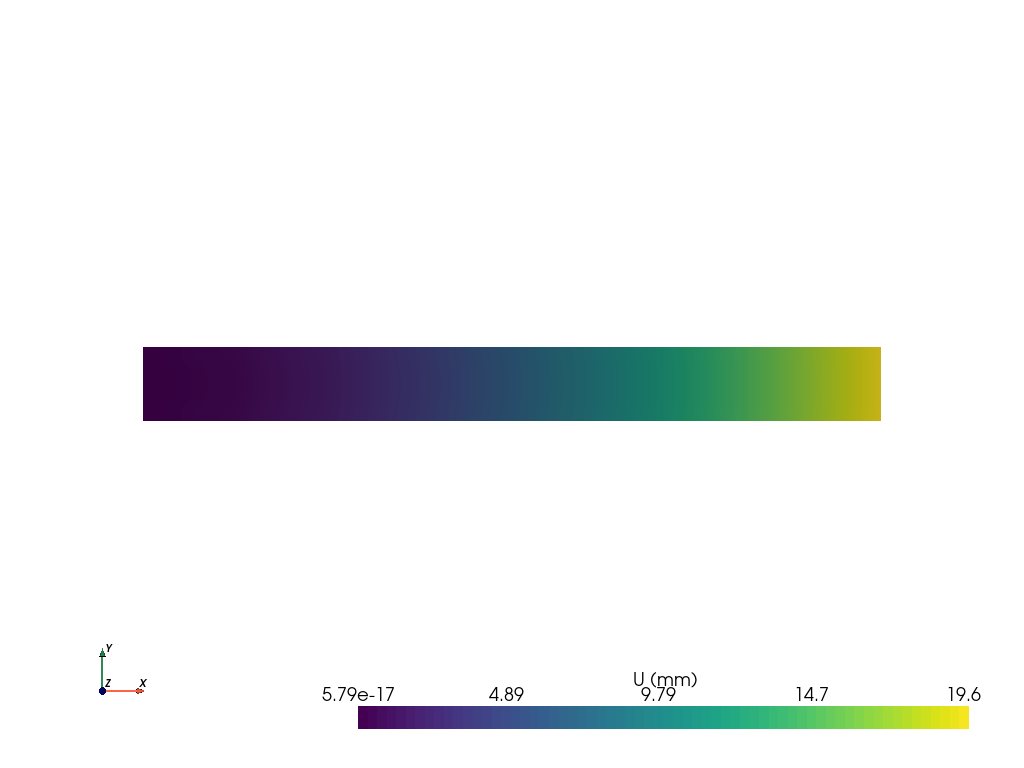

In [11]:
m = pv.read("mfu.vtk")
m.plot(scalars="U", cpos="xy", jupyter_backend="static", scalar_bar_args={"title": "U (mm)"})

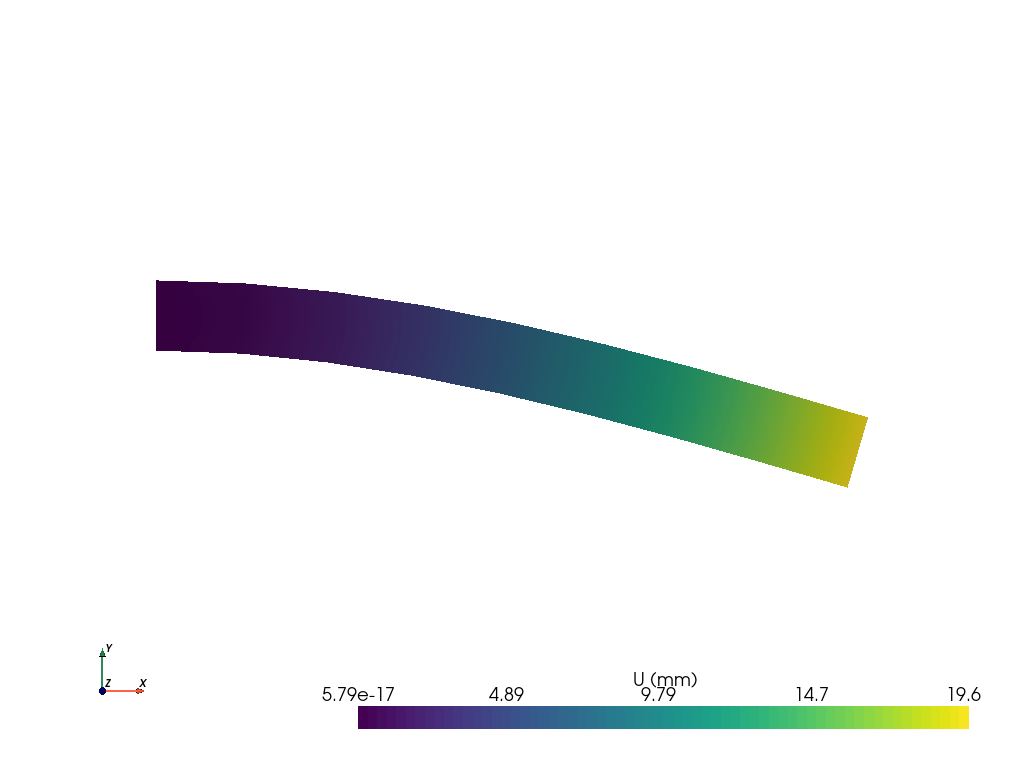

In [12]:
w = m.warp_by_vector("U", factor=100.0)
w.plot(scalars="U", cpos="xy", jupyter_backend="static", scalar_bar_args={"title": "U (mm)"})

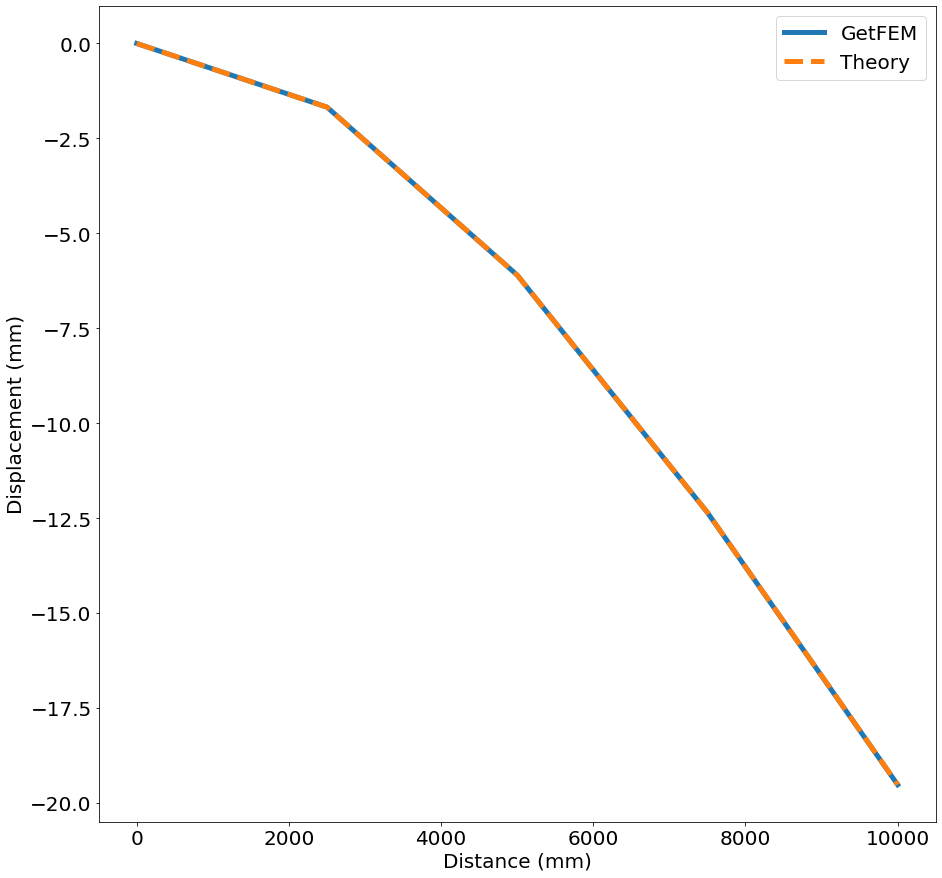

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
sampled = m.sample_over_line([0, h, 0], [L, h, 0], 4)
U = sampled["U"][:, 1]
ax.plot(X, U, label="GetFEM", linewidth=5.0)

I = b * h ** 3 / 12.0
P = F * (b * h)
u = -(P / (E * I)) * (X ** 3 / 6.0 - L * X ** 2 / 2.0)
ax.plot(X, u, label="Theory", linestyle="dashed", linewidth=5.0)
ax.legend()
ax.set_xlabel("Distance (mm)")
ax.set_ylabel("Displacement (mm)")
plt.show()